1. maybe run HMM or confidence interval to decide when regime changes and model fails. or add it into screener 
2. Build out screener
3. Make an options screener to screen for alerts and backtested profitability while remaining within regime. 
4. PCA and greeks to optimize features /done
5. Remove lag /done
6. Make the model a triple barrier: make it more robust in labeling / generating correct classes 
7. drop features when not predictive
8. weight trades by probability 
9. do a screener that tests prediction power with the hgb model
10. MAKE THE EXTREMA considerablyu higher / lower than surrounding values, cancel out noise.  
idea: take fidelity data and do a big KNN on options prices to discover timing, big orders, prices, roc, etc. 
also: break the bar data down by volume / dollar volume? 
also: add a few periods wait into backtest purchasing? 
trade in a specific environment, like post-earnings. ALSO get order book to optoimize trades. 
----Use lorentzian distance as the classifier method / normalize the data to remove drift bias lgbm ranker for screener 

 
Order book data for optimization 
Realtime sentiment / newsflow
Spread trading contracts 
price/vol/gamma spreads 

OTHER:
Fix the optimum buy sell on lookahead 
pull in 2 chains and forecast vol / up movements for a gamma spread strat. 


Screener filter ideas: 
1. price * volume > 600M
2. roc over a period >0
3. SMA for period or moving rate of change positive trending 
4. low implied volatility 
5. good near expiry options volume 
6. near expiry decreasing volatility
 Other ideas: HMM screener to detect consistent current option regime 
7. Make a gradient boost screener that can find stocks poised at low iv/hv with increasing volume/price/option feature for options trading, 

In [923]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix1.csv")
datafix = pd.read_csv(desktop_path)
desktop_path2 = os.path.join(os.path.expanduser("~"), "Desktop", "datafix2.csv")
datafix2 = pd.read_csv(desktop_path2)

In [924]:
# Ensure both DataFrames are indexed by "Date"
datafix = datafix.set_index("Date")
datafix2 = datafix2.set_index("Date")

# Find the latest of the two first dates
start_date = max(datafix.index.min(), datafix2.index.min())

# Trim both DataFrames to start at that date
datafix = datafix[datafix.index >= start_date]
datafix2 = datafix2[datafix2.index >= start_date]
datafix, datafix2 = datafix.align(datafix2, join='inner', axis=0)


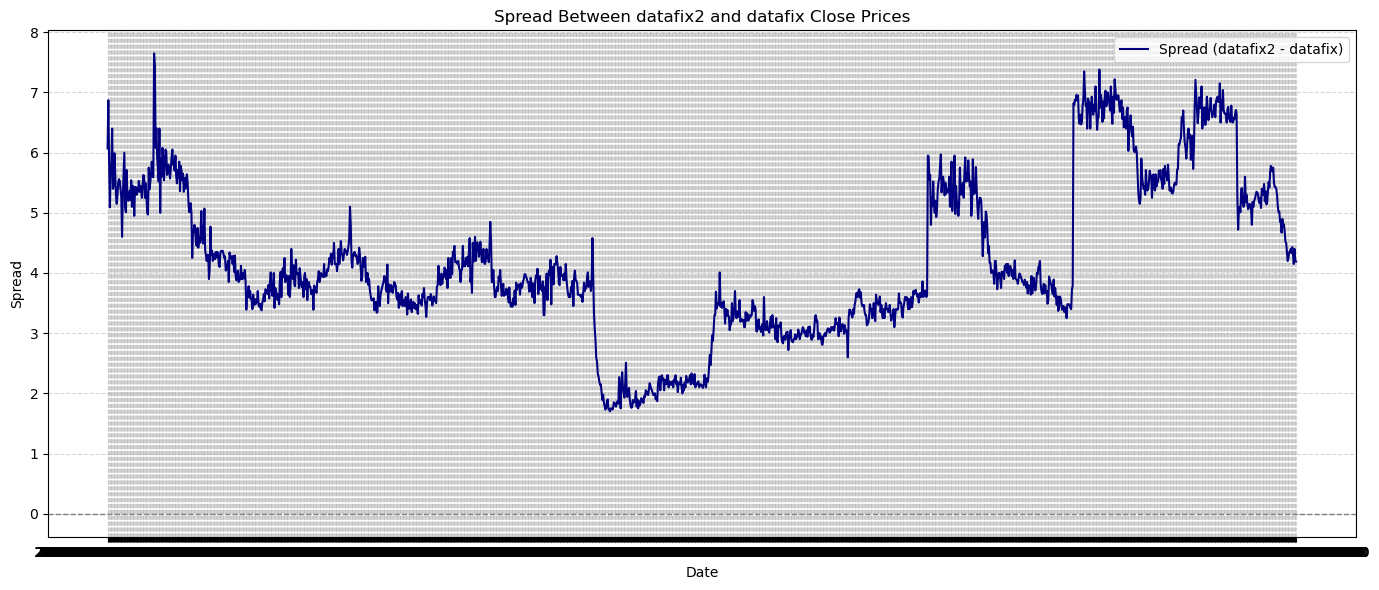

In [925]:
import matplotlib.pyplot as plt

# Calculate the spread
datafix["spread"] = datafix["Close"] - datafix2["Close"]

# Plot the spread
plt.figure(figsize=(14, 6))
plt.plot(datafix.index, datafix["spread"], label="Spread (datafix2 - datafix)", color='navy')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Spread Between datafix2 and datafix Close Prices")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [926]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC,spread
Date,,,,,,,,,,,,,,,,,,
2025-06-05 19:55:00,41.07,41.65,41.07,41.65,5,41.650000,NaN,0.000000,0.000000,0.000000,43.0,284.70,310,0.0429,p,0.696613,NaN,6.07
2025-06-06 13:30:00,33.60,33.77,31.20,33.75,12,34.409962,-17.383044,-0.630199,-0.126040,-0.504160,42.0,295.14,310,0.0429,p,0.651535,-6.471118,6.87
2025-06-06 13:35:00,32.26,32.30,31.95,31.95,26,31.182538,-9.379330,-1.260353,-0.352903,-0.907451,42.0,295.14,310,0.0429,p,0.606239,-6.952216,5.85
2025-06-06 13:40:00,32.35,32.35,31.70,32.14,33,30.459355,-2.319191,-1.724544,-0.627231,-1.097313,42.0,295.14,310,0.0429,p,0.611025,0.789513,5.09
2025-06-06 13:45:00,32.20,32.78,32.16,32.75,13,30.686291,0.745044,-2.019912,-0.905767,-1.114145,42.0,295.14,310,0.0429,p,0.626383,2.513492,5.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 19:35:00,8.90,9.05,8.60,8.60,107,8.509127,-0.871403,-0.685922,-0.678334,-0.007588,8.0,309.87,310,0.0429,p,0.474521,-3.664049,4.30
2025-07-10 19:40:00,8.60,8.60,8.25,8.35,169,8.389702,-1.403499,-0.693841,-0.681436,-0.012406,8.0,309.87,310,0.0429,p,0.460849,-2.881256,4.15
2025-07-10 19:45:00,8.45,9.10,8.38,8.70,1,8.393751,0.048260,-0.664219,-0.677992,0.013774,8.0,309.87,310,0.0429,p,0.479990,4.153457,4.40


In [927]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# --- Black-Scholes Greeks calculation (without Rho) ---
def bs_greeks(S, K, T, r, sigma, option_type):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan, np.nan, np.nan, np.nan  # Handle invalid/missing data
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        delta = norm.cdf(d1)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2))
    else:
        delta = norm.cdf(d1) - 1
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return delta, gamma, vega, theta

r = 0.05  # Risk-free rate

def calc_row_greeks(row):
    S = row['stock price']
    K = row['strike']
    T = max(row['days_to_expiry'] / 365, 1e-6)  # Avoid division by zero
    sigma = row['IV']
    option_type = row['type'].lower()
    return bs_greeks(S, K, T, r, sigma, option_type)

# --- Apply to datafix ---
greeks1 = datafix.apply(calc_row_greeks, axis=1, result_type='expand')
greeks1.columns = ['delta', 'gamma', 'vega', 'theta']
datafix = pd.concat([datafix, greeks1], axis=1)

# --- Apply to datafix2 ---
greeks2 = datafix2.apply(calc_row_greeks, axis=1, result_type='expand')
greeks2.columns = ['delta', 'gamma', 'vega', 'theta']
datafix2 = pd.concat([datafix2, greeks2], axis=1)


In [928]:
datafix2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'delta', 'gamma', 'vega',
       'theta'],
      dtype='object')

In [929]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")


In [930]:
datafix2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'delta', 'gamma', 'vega',
       'theta'],
      dtype='object')

In [931]:
import numpy as np

window = 20

# For datafix
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)

# For datafix2, with suffix '2'
datafix2["MACD_Hist_std"] = (
    (datafix2["MACD_Hist"] - datafix2["MACD_Hist"].rolling(window).mean()) /
    datafix2["MACD_Hist"].rolling(window).std()
)


In [932]:
datafix2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'delta', 'gamma', 'vega',
       'theta', 'MACD_Hist_std'],
      dtype='object')

In [933]:
from arch import arch_model
import numpy as np

# --- For datafix ---
iv_series = pd.to_numeric(datafix['IV'], errors='coerce')
iv_series = iv_series.replace([np.inf, -np.inf], np.nan).dropna()

if len(iv_series) > 10:  # GARCH needs enough data points
    model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    conditional_vol = model_fit.conditional_volatility
    # Fill NaN in the original DataFrame, align by index
    datafix['IV_garch_vol'] = np.nan
    datafix.loc[conditional_vol.index, 'IV_garch_vol'] = conditional_vol
else:
    datafix['IV_garch_vol'] = np.nan

# --- For datafix2 (with suffix '2') ---
iv_series2 = pd.to_numeric(datafix2['IV'], errors='coerce')
iv_series2 = iv_series2.replace([np.inf, -np.inf], np.nan).dropna()

if len(iv_series2) > 10:
    model2 = arch_model(iv_series2, mean='Zero', vol='GARCH', p=1, q=1)
    model_fit2 = model2.fit(disp='off')
    conditional_vol2 = model_fit2.conditional_volatility
    datafix2['IV_garch_vol'] = np.nan
    datafix2.loc[conditional_vol2.index, 'IV_garch_vol'] = conditional_vol2
else:
    datafix2['IV_garch_vol'] = np.nan


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006515. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005122. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [934]:
datafix2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'delta', 'gamma', 'vega',
       'theta', 'MACD_Hist_std', 'IV_garch_vol'],
      dtype='object')

In [935]:
import pandas as pd

def compute_rsi(df, column="Close", period=14, rsi_col="RSI"):
    delta = df[column].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df[rsi_col] = rsi
    return df

# For datafix
datafix = compute_rsi(datafix, column="Close", period=14, rsi_col="RSI")
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()

# For datafix2, with suffix '2'
datafix2 = compute_rsi(datafix2, column="Close", period=14, rsi_col="RSI")
datafix2['rsiMA_14'] = datafix2['RSI'].rolling(window=14).mean()


In [936]:
datafix2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'delta', 'gamma', 'vega',
       'theta', 'MACD_Hist_std', 'IV_garch_vol', 'RSI', 'rsiMA_14'],
      dtype='object')

In [937]:
import pandas as pd

def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9, suffix=''):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df[f'MACDvol{suffix}'] = macd
    df[f'Signalvol{suffix}'] = signal_line
    df[f'MACD_Histvol{suffix}'] = macd_hist
    df[f'MACDROCvol{suffix}'] = macd_hist.pct_change()
    return df

# Calculate MACD features for both dataframes
datafix = calculate_macd(datafix, close_col='IV_garch_vol', suffix='')
datafix2 = calculate_macd(datafix2, close_col='IV_garch_vol', suffix='')

# Combine all columns from both dataframes, aligning by index
datafix_combined = pd.concat([datafix, datafix2], axis=1)


In [938]:
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9, suffix=''):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df[f'MACDkalman{suffix}'] = macd
    df[f'Signalkalman{suffix}'] = signal_line
    df[f'MACD_Histkalman{suffix}'] = macd_hist
    df[f'MACDROCkal{suffix}'] = macd_hist.pct_change()
    return df

# Apply to datafix
datafix = calculate_macd(datafix, close_col='Kalman', suffix='')

# Apply to datafix2, with '2' suffix
datafix2 = calculate_macd(datafix2, close_col='Kalman', suffix='')

# If you want to combine all columns into one DataFrame (optional):
#datafix_combined = pd.concat([datafix, datafix2], axis=1)


In [939]:
lag = 9

# For datafix
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()
datafix["stocktrend"] = datafix["stock price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"]
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()

# For datafix2, with suffix '2'
datafix2["Kalman_Roc_roll"] = datafix2["Kalman_Roc"].rolling(lag).mean()
datafix2["MACDROCvolroll9"] = datafix2["MACDROCvol"].rolling(9).mean()
datafix2["MACDROCkalroll9"] = datafix2["MACDROCkal"].rolling(9).mean()
datafix2["stocktrend"] = datafix2["stock price"].pct_change().rolling(3).mean()
datafix2["sma30"] = datafix2["Close"].rolling(20).mean()
datafix2["smaspread"] = datafix2["sma30"] - datafix2["Close"]
datafix2["IV_garch_volsma"] = datafix2['IV_garch_vol'].pct_change().rolling(18).mean()
datafix2["kalmansma"] = datafix2['Kalman'].pct_change().rolling(5).mean()


In [940]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# For datafix
datafix['log_return'] = np.log(datafix['Close'] / datafix['Close'].shift(1))
returns = datafix['log_return'].dropna().values.reshape(-1, 1)

model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=500, random_state=42)
model.fit(returns)
hidden_states = model.predict(returns)

# Align DataFrame index after dropna
datafix = datafix.iloc[1:]
datafix['hmm_state'] = hidden_states

# For datafix2, with suffix '2'
datafix2['log_return2'] = np.log(datafix2['Close'] / datafix2['Close'].shift(1))
returns2 = datafix2['log_return2'].dropna().values.reshape(-1, 1)

model2 = GaussianHMM(n_components=2, covariance_type="diag", n_iter=500, random_state=42)
model2.fit(returns2)
hidden_states2 = model2.predict(returns2)

datafix2 = datafix2.iloc[1:]
datafix2['hmm_state2'] = hidden_states2


Model is not converging.  Current: 3039.6535904912494 is not greater than 3039.660926119454. Delta is -0.007335628204600653


In [941]:
# Random forest settings 
buy_thresh = 0.5  # Threshold for buy signal(probability of rf outcome) df.2
sell_thresh = -0.5  # Threshold for sell signal(probability of rf outcome) df-.2
neighbors = 10
backtest_ma = 1 # Buy/sell moving average for rolling RF signal and backtest | keep same as stat window df20

In [942]:
datafix.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'spread', 'delta', 'gamma',
       'vega', 'theta', 'MACD_Hist_std', 'IV_garch_vol', 'RSI', 'rsiMA_14',
       'MACDvol', 'Signalvol', 'MACD_Histvol', 'MACDROCvol', 'MACDkalman',
       'Signalkalman', 'MACD_Histkalman', 'MACDROCkal', 'Kalman_Roc_roll',
       'MACDROCvolroll9', 'MACDROCkalroll9', 'stocktrend', 'sma30',
       'smaspread', 'IV_garch_volsma', 'kalmansma', 'log_return', 'hmm_state'],
      dtype='object')

In [943]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from hmmlearn import hmm

def entropy_hmm_pipeline(df, close_col='Close', prefix=''):
    # 1. Calculate log returns
    returns = np.log(df[close_col] / df[close_col].shift(1)).dropna()
    # 2. Calculate windowed entropy
    def windowed_entropy(series, window_size=30, bins=10):
        entropies = []
        indices = []
        for i in range(len(series) - window_size + 1):
            window = series.iloc[i:i+window_size]
            hist, _ = np.histogram(window, bins=bins, density=True)
            hist = hist[hist > 0]
            ent = entropy(hist, base=2)
            entropies.append(ent)
            indices.append(series.index[i + window_size - 1])
        return pd.Series(entropies, index=indices)
    entropy_series = windowed_entropy(returns, window_size=30, bins=10)
    # 3. Fit HMM and infer regimes
    X = entropy_series.values.reshape(-1, 1)
    model = hmm.GaussianHMM(n_components=2, n_iter=100, random_state=42)
    model.fit(X)
    hidden_states = model.predict(X)
    entropy_df = pd.DataFrame({
        f'entropy{prefix}': entropy_series,
        f'regime{prefix}': hidden_states
    })
    # 4. Add lagged entropy features
    for lag in range(1, 6):
        entropy_df[f'entropy_lag{lag}{prefix}'] = entropy_df[f'entropy{prefix}'].shift(lag)
    entropy_df = entropy_df.dropna()
    # 5. Align Close prices and create lagged Close features
    close_tmp_col = f'Close{prefix}'
    entropy_df[close_tmp_col] = df[close_col].reindex(entropy_df.index)
    entropy_df = entropy_df.dropna(subset=[close_tmp_col, f'regime{prefix}'])
    for lag in range(1, 6):
        entropy_df[f'Close_lag{lag}{prefix}'] = entropy_df[close_tmp_col].shift(lag)
    entropy_df = entropy_df.dropna(subset=[f'Close_lag{lag}{prefix}' for lag in range(1, 6)])
    entropy_df = entropy_df.drop(columns=[close_tmp_col])
    # 6. Forecast next regime
    def forecast_next_hmm_regime(hmm_model, entropy_df):
        current_regime = int(entropy_df[f'regime{prefix}'].iloc[-1])
        transmat = hmm_model.transmat_
        next_state_probs = transmat[current_regime]
        forecasted_next_regime = np.argmax(next_state_probs)
        return current_regime, next_state_probs, forecasted_next_regime
    current_regime, next_state_probs, forecasted_next_regime = forecast_next_hmm_regime(model, entropy_df)
    entropy_df[f'forecasted_next_regime{prefix}'] = np.nan
    entropy_df.at[entropy_df.index[-1], f'forecasted_next_regime{prefix}'] = forecasted_next_regime
    # 7. Join regime column back to main df for downstream use
    regime_col = f'regime{prefix}'
    df[f'hmm_state{prefix}'] = np.nan
    df.loc[entropy_df.index, f'hmm_state{prefix}'] = entropy_df[regime_col]
    # (Optional) join all entropy features if desired:
    # df = df.join(entropy_df, how='left')
    return df, entropy_df, model

# --- Apply to datafix and datafix2 ---
datafix, entropy_df, model = entropy_hmm_pipeline(datafix, close_col='Close', prefix='')
datafix2, entropy_df2, model2 = entropy_hmm_pipeline(datafix2, close_col='Close', prefix='')

# Now both datafix and datafix2 have hmm_state/hmm_state2 columns and entropy features (if you join them)


In [944]:
import pandas as pd
pd.set_option('display.max_columns', None)
display(datafix2)  # or just datafix2 in a Jupyter cell


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC,delta,gamma,vega,theta,MACD_Hist_std,IV_garch_vol,RSI,rsiMA_14,MACDvol,Signalvol,MACD_Histvol,MACDROCvol,MACDkalman,Signalkalman,MACD_Histkalman,MACDROCkal,Kalman_Roc_roll,MACDROCvolroll9,MACDROCkalroll9,stocktrend,sma30,smaspread,IV_garch_volsma,kalmansma,log_return2,hmm_state2,hmm_state
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-06 13:30:00,27.45,29.07,26.00,26.88,208,27.606794,-22.409237,-0.694017,-0.138803,-0.555214,42.0,295.14,300,0.0429,p,0.627344,-11.253629,-0.477396,0.006342,39.876634,-100.319998,NaN,0.703941,NaN,NaN,0.005237,0.001047,0.004189,inf,-0.636039,-0.127208,-0.508831,-inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.280401,1,NaN
2025-06-06 13:35:00,26.85,27.40,26.00,26.10,146,25.028737,-9.338488,-1.292076,-0.369458,-0.922618,42.0,295.14,300,0.0429,p,0.607790,-3.116903,-0.479354,0.006547,39.887266,-96.970035,NaN,0.626328,NaN,NaN,0.003088,0.001456,0.001633,-0.610235,-1.332769,-0.368320,-0.964449,0.895420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029447,0,NaN
2025-06-06 13:40:00,27.00,27.29,26.20,27.05,200,25.079402,0.202430,-1.670132,-0.629593,-1.040540,42.0,295.14,300,0.0429,p,0.631606,3.918469,-0.476975,0.006298,39.874219,-101.049650,NaN,0.607285,NaN,NaN,-0.000149,0.001135,-0.001284,-1.786175,-1.859410,-0.666538,-1.192872,0.236843,NaN,NaN,NaN,0.012223,NaN,NaN,NaN,NaN,0.035752,0,NaN
2025-06-06 13:45:00,27.15,27.50,26.66,27.10,143,25.293819,0.854950,-1.943309,-0.892336,-1.050973,42.0,295.14,300,0.0429,p,0.632860,0.198492,-0.476851,0.006286,39.873502,-101.264221,NaN,0.630482,NaN,NaN,-0.000833,0.000741,-0.001574,0.226453,-2.233727,-0.979976,-1.253751,0.051035,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.001847,0,NaN
2025-06-06 13:50:00,26.99,29.46,26.99,29.46,66,26.769316,5.833431,-1.946928,-1.103255,-0.843674,42.0,295.14,300,0.0429,p,0.692060,9.354403,-0.471176,0.005743,39.836464,-111.375652,NaN,0.631703,NaN,NaN,-0.001263,0.000340,-0.001603,0.018077,-2.383835,-1.260748,-1.123088,-0.104218,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.049714,0.083500,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 19:35:00,4.54,4.59,4.30,4.30,187,4.259074,-1.284100,-0.448619,-0.438623,-0.009995,8.0,309.87,300,0.0429,p,0.467887,-2.590698,-0.302310,0.016255,16.005686,-165.941261,2.307729,0.483617,27.799266,29.226266,-0.025205,-0.023714,-0.001491,-0.442220,-0.492529,-0.440970,-0.051558,-0.214803,-1.627885,-0.128736,-0.081004,0.000000,4.9115,0.6115,-0.006270,-0.008792,-0.045462,0,0.0
2025-07-10 19:40:00,4.30,4.30,4.10,4.20,1,4.192654,-1.559505,-0.450385,-0.440976,-0.009409,8.0,309.87,300,0.0429,p,0.461636,-1.335848,-0.300192,0.016423,15.955095,-163.164130,1.953788,0.471602,26.364145,28.841729,-0.025242,-0.024020,-0.001223,-0.180033,-0.491262,-0.451029,-0.040234,-0.219649,-1.512115,-0.157846,-0.106017,0.000000,4.8465,0.6465,-0.009152,-0.008542,-0.023530,0,0.0
2025-07-10 19:45:00,4.15,4.62,4.15,4.30,385,4.170418,-0.530348,-0.438658,-0.440512,0.001854,8.0,309.87,300,0.0429,p,0.467887,1.353935,-0.302310,0.016255,16.005686,-165.941261,1.917733,0.465571,30.242359,28.433371,-0.025465,-0.024309,-0.001156,-0.054379,-0.486446,-0.458112,-0.028334,-0.295776,-1.198991,-0.164426,-0.141120,0.000000,4.7740,0.4740,-0.008694,-0.008313,0.023530,0,0.0


In [945]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

# --- 1. Feature List ---
feature_list = [
    'Close', 'Volume', 'Kalman', 'Kalman_Roc', 'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry',
    'stock price', 'strike', 'rfr', 'IV', 'IVROC', 'delta', 'gamma', 'vega', 'theta',
    'MACD_Hist_std', 'IV_garch_vol', 'RSI', 'rsiMA_14', 'MACDvol', 'Signalvol', 'MACD_Histvol',
    'MACDROCvol', 'MACDkalman', 'Signalkalman', 'MACD_Histkalman', 'MACDROCkal', 'Kalman_Roc_roll',
    'MACDROCvolroll9', 'MACDROCkalroll9', 'stocktrend', 'sma30', 'smaspread', 'IV_garch_volsma',
    'kalmansma', 'hmm_state'
]

# --- 2. Rename Columns to Indicate Source ---
datafix1_renamed = datafix[feature_list].add_suffix('_fix1')
datafix2_renamed = datafix2[feature_list].add_suffix('_fix2')

# --- 3. Concatenate Features Side-by-Side ---
X = pd.concat([datafix1_renamed, datafix2_renamed], axis=1)

# --- 4. Forward-only Local Minima Labeling on Kalman (from datafix) ---
def forward_local_extrema(series, order, mode='min'):
    idxs = []
    n = len(series)
    for i in range(n - order):
        window = series[i+1:i+order+1]
        if mode == 'min':
            if np.all(series[i] < window):
                idxs.append(i)
        elif mode == 'max':
            if np.all(series[i] > window):
                idxs.append(i)
    return np.array(idxs)

 # or any window you want
series = datafix['spread'].values
min_idx = forward_local_extrema(series, neighbors, mode='min')

# --- 5. Build Target Array (1 for local min, 0 otherwise) ---
y = np.zeros(len(X), dtype=int)
y[min_idx] = 1

# --- 6. Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 7. Train HGB Classifier ---
hgbc = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
hgbc.fit(X_train, y_train)

# --- 8. Predict and Evaluate ---
y_pred = hgbc.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       277
           1       1.00      0.06      0.11        35

    accuracy                           0.89       312
   macro avg       0.95      0.53      0.53       312
weighted avg       0.91      0.89      0.85       312



In [946]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

# --- 1. Feature List ---
feature_list = [
    'Close', 'Volume', 'Kalman', 'Kalman_Roc', 'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry',
    'stock price', 'strike', 'rfr', 'IV', 'IVROC', 'delta', 'gamma', 'vega', 'theta',
    'MACD_Hist_std', 'IV_garch_vol', 'RSI', 'rsiMA_14', 'MACDvol', 'Signalvol', 'MACD_Histvol',
    'MACDROCvol', 'MACDkalman', 'Signalkalman', 'MACD_Histkalman', 'MACDROCkal', 'Kalman_Roc_roll',
    'MACDROCvolroll9', 'MACDROCkalroll9', 'stocktrend', 'sma30', 'smaspread', 'IV_garch_volsma',
    'kalmansma', 'hmm_state'
]

# --- 2. Rename Columns to Indicate Source ---
datafix1_renamed = datafix[feature_list].add_suffix('_fix1')
datafix2_renamed = datafix2[feature_list].add_suffix('_fix2')

# --- 3. Concatenate Features Side-by-Side ---
X = pd.concat([datafix1_renamed, datafix2_renamed], axis=1)

# --- 4. Forward-only Local Maxima Labeling on spread (from datafix) ---
def forward_local_extrema(series, order, mode='max'):
    idxs = []
    n = len(series)
    for i in range(n - order):
        window = series[i+1:i+order+1]
        if mode == 'min':
            if np.all(series[i] < window):
                idxs.append(i)
        elif mode == 'max':
            if np.all(series[i] > window):
                idxs.append(i)
    return np.array(idxs)

neighbors = 10  # window size for forward search
series = datafix['spread'].values
max_idx = forward_local_extrema(series, neighbors, mode='max')

# --- 5. Build Target Array (1 for local max, 0 otherwise) ---
y = np.zeros(len(X), dtype=int)
y[max_idx] = 1

# --- 6. Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 7. Train HGB Classifier ---
hgbc = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
hgbc.fit(X_train, y_train)

# --- 8. Predict and Evaluate ---
y_pred = hgbc.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.98      0.93       276
           1       0.00      0.00      0.00        36

    accuracy                           0.87       312
   macro avg       0.44      0.49      0.46       312
weighted avg       0.78      0.87      0.82       312



In [947]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- 1. Feature List ---
feature_list = [
    'Close', 'Volume', 'Kalman', 'Kalman_Roc', 'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry',
    'stock price', 'strike', 'rfr', 'IV', 'IVROC', 'delta', 'gamma', 'vega', 'theta',
    'MACD_Hist_std', 'IV_garch_vol', 'RSI', 'rsiMA_14', 'MACDvol', 'Signalvol', 'MACD_Histvol',
    'MACDROCvol', 'MACDkalman', 'Signalkalman', 'MACD_Histkalman', 'MACDROCkal', 'Kalman_Roc_roll',
    'MACDROCvolroll9', 'MACDROCkalroll9', 'stocktrend', 'sma30', 'smaspread', 'IV_garch_volsma',
    'kalmansma', 'hmm_state'
]

# --- 2. Prepare Features (for both training and prediction) ---
features_fix1 = datafix[feature_list].add_suffix('_fix1')
features_fix2 = datafix2[feature_list].add_suffix('_fix2')
features_df = pd.concat([features_fix1, features_fix2], axis=1)

# --- 3. Labeling Functions ---
def forward_local_extrema(series, order, mode='min'):
    idxs = []
    n = len(series)
    for i in range(n - order):
        window = series[i+1:i+order+1]
        if mode == 'min':
            if np.all(series[i] < window):
                idxs.append(i)
        elif mode == 'max':
            if np.all(series[i] > window):
                idxs.append(i)
    return np.array(idxs)



# --- 4. Build Buy Labels (local minima on spread) ---
min_idx = forward_local_extrema(datafix['spread'].values, neighbors, mode='min')
y_buy = np.zeros(len(features_df), dtype=int)
y_buy[min_idx] = 1

# --- 5. Build Sell Labels (local maxima on spread) ---
max_idx = forward_local_extrema(datafix['spread'].values, neighbors, mode='max')
y_sell = np.zeros(len(features_df), dtype=int)
y_sell[max_idx] = 1

# --- 6. Train/Test Split (optional, for evaluation) ---
X_train, X_test, y_buy_train, y_buy_test = train_test_split(features_df, y_buy, test_size=0.2, random_state=42)
_, _, y_sell_train, y_sell_test = train_test_split(features_df, y_sell, test_size=0.2, random_state=42)

# --- 7. Train Buy Model ---
hgb_buy = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
hgb_buy.fit(X_train, y_buy_train)
print("Buy model:")
print(classification_report(y_buy_test, hgb_buy.predict(X_test)))

# --- 8. Train Sell Model ---
hgb_sell = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
hgb_sell.fit(X_train, y_sell_train)
print("Sell model:")
print(classification_report(y_sell_test, hgb_sell.predict(X_test)))

# --- 9. Get Buy and Sell Probabilities for ALL ROWS ---
datafix["Buy_Prob"] = hgb_buy.predict_proba(features_df)[:, 1]
datafix["Sell_Prob"] = hgb_sell.predict_proba(features_df)[:, 1]

# --- 10. Compute Combined Score ---
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]



def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

# --- 12. Apply Signal Logic ---
datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)

# --- 13. (Optional) Display Signal Counts ---
print(datafix["Combined_Signal"].value_counts())


Buy model:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       277
           1       1.00      0.06      0.11        35

    accuracy                           0.89       312
   macro avg       0.95      0.53      0.53       312
weighted avg       0.91      0.89      0.85       312

Sell model:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       276
           1       0.00      0.00      0.00        36

    accuracy                           0.87       312
   macro avg       0.44      0.49      0.46       312
weighted avg       0.78      0.87      0.82       312

Combined_Signal
hold    1324
sell     131
buy      104
Name: count, dtype: int64


In [948]:
import plotly.graph_objects as go

fig = go.Figure()

# Close price from datafix (main)
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["Close"],
    mode='lines', name='Close (fix1)', line=dict(color='red', dash='dot', width=2)
))

# Close price from datafix2
fig.add_trace(go.Scatter(
    x=datafix2.index, y=datafix2["Close"],
    mode='lines', name='Close (fix2)', line=dict(color='blue', width=2, dash='dot')
))

# Spread (from datafix)
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["spread"],
    mode='lines', name='Spread', line=dict(color='black', width=2)
))

# Combined buy signals (green upward triangle) ON SPREAD
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
fig.add_trace(go.Scatter(
    x=buy_signals.index, y=buy_signals["spread"],
    mode='markers', name='Combined Buy (on spread)',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))

# Combined sell signals (red downward triangle) ON SPREAD
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
fig.add_trace(go.Scatter(
    x=sell_signals.index, y=sell_signals["spread"],
    mode='markers', name='Combined Sell (on spread)',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))

# Draw prediction start line
split_idx_bar = int(len(datafix) * 0.7)
split_date_bar = datafix.index[split_idx_bar]
fig.add_vline(x=split_date_bar, line=dict(color='black', dash='dash', width=2))

# Layout settings
fig.update_layout(
    title="Close Prices (fix1, fix2), Spread, and Combined Buy/Sell Signals (on Spread)",
    xaxis_title="Date",
    yaxis_title="Price / Spread",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


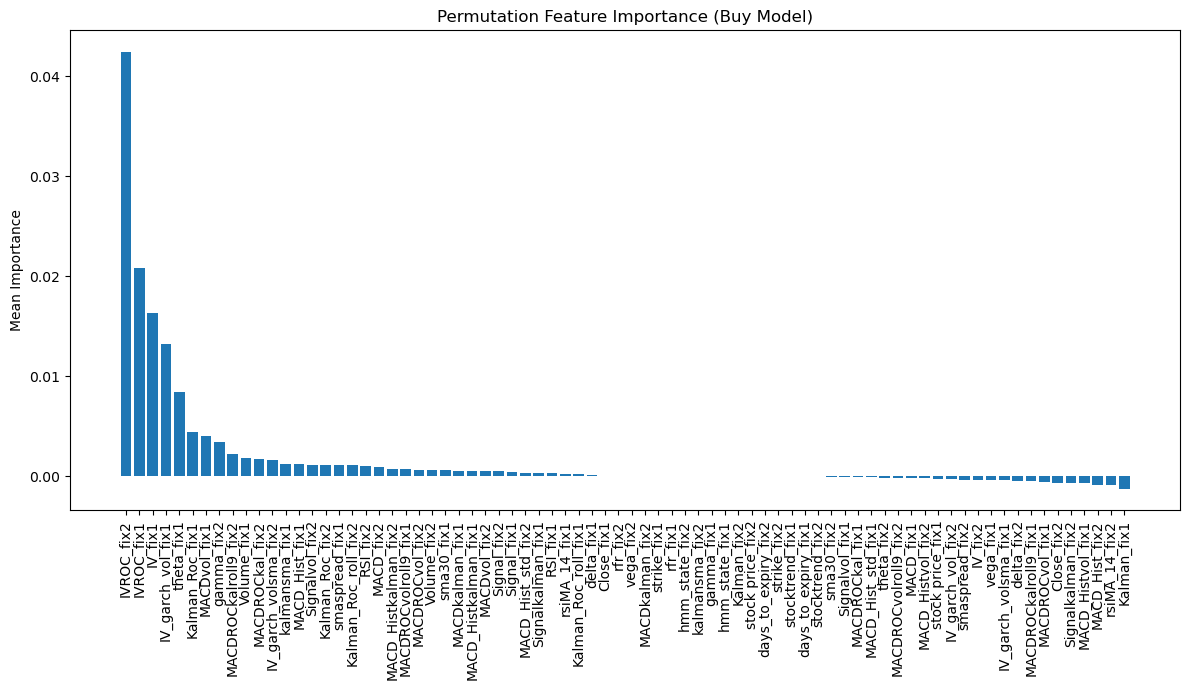

In [949]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming your buy model is hgb_buy and your training data is features_df and y_buy
# You can also use hgb_sell and y_sell for the sell model

# Calculate permutation importance (use training or test set as appropriate)
result = permutation_importance(
    hgb_sell, features_df, y_sell, n_repeats=10, random_state=42, n_jobs=-1
)

# Get sorted indices for feature importance
sorted_idx = result.importances_mean.argsort()[::-1]

# Plot
plt.figure(figsize=(12, 7))
plt.bar(range(len(features_df.columns)), result.importances_mean[sorted_idx])
plt.xticks(range(len(features_df.columns)), features_df.columns[sorted_idx], rotation=90)
plt.title("Permutation Feature Importance (Buy Model)")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()


Total Strategy $ Return (Last 30%): $1314.00


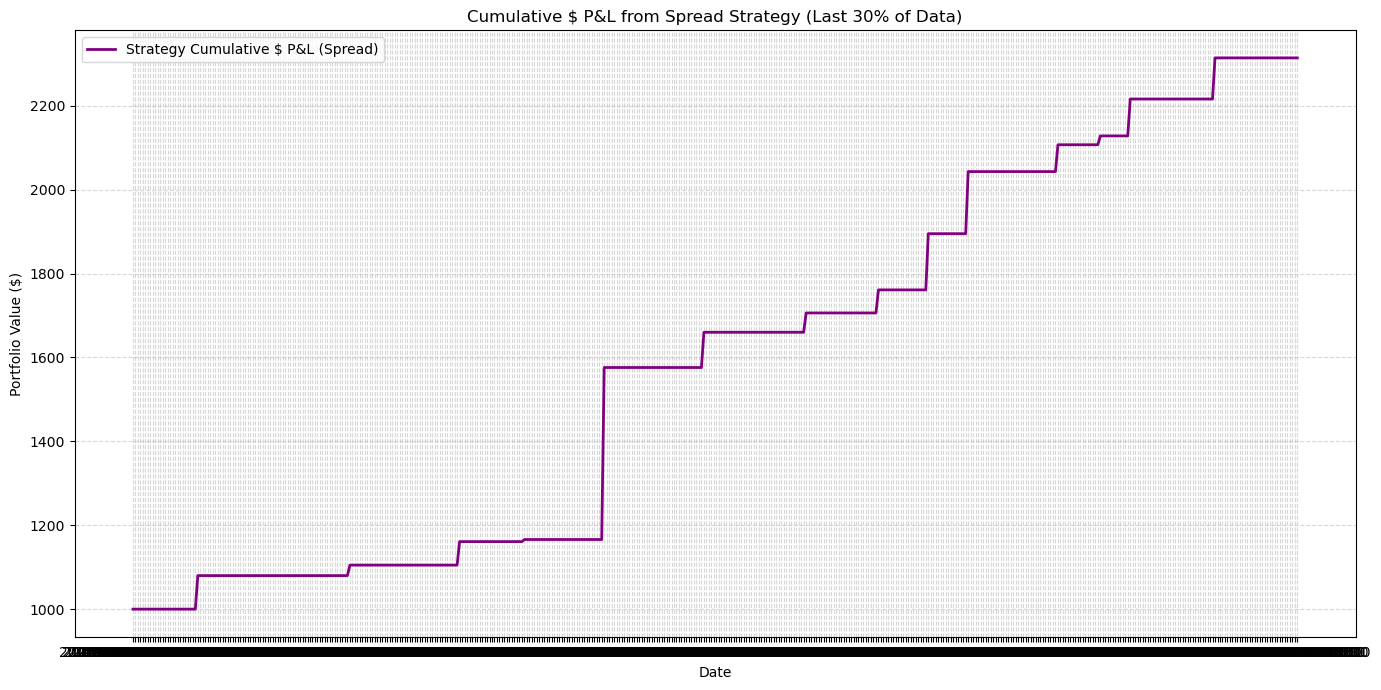

In [956]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Map 'buy' to 1, 'sell' to -1
datafix['Trade_Signal1'] = datafix['Combined_Signal'].map({'buy': 1, 'sell': -1})

# --- 1. Slice the last 30% of the data ---
start_idx = int(len(datafix) * 0.7)
datafix_last30 = datafix.iloc[start_idx:].copy()

# --- 2. Initialize variables ---
initial_capital = 1000
capital = initial_capital
position = 0  # 1 for long, 0 for flat
positions = []
portfolio = []
entry_spread = None
fee = 0  # set to a dollar fee per trade if desired

# --- 3. Backtest loop: $ P&L on spread (spread is in 100s of $) ---
for idx, row in datafix_last30.iterrows():
    signal = row['Trade_Signal1']
    spread = row['spread']

    # Enter trade: record entry spread
    if signal == 1 and position == 0:
        position = 1
        entry_spread = spread
        capital -= fee  # optional: subtract entry fee

    # Exit trade: calculate P&L as $ change in spread (scaled)
    elif signal == -1 and position == 1:
        pnl = (spread - entry_spread) * 100  # scale by 100
        capital += pnl
        capital -= fee  # optional: subtract exit fee
        position = 0
        entry_spread = None

    # Portfolio value: capital (no open P&L on current spread)
    portfolio.append(capital)
    positions.append(position)

# --- 4. Attach results ---
datafix_last30['Position'] = positions
datafix_last30['Portfolio'] = portfolio

# --- 5. Print final results ---
total_return = datafix_last30['Portfolio'].iloc[-1] - initial_capital
print(f"Total Strategy $ Return (Last 30%): ${total_return:.2f}")

# --- 6. Plot ---
plt.figure(figsize=(14, 7))
plt.plot(datafix_last30.index, datafix_last30['Portfolio'], label='Strategy Cumulative $ P&L (Spread)', color='purple', linewidth=2)
plt.title('Cumulative $ P&L from Spread Strategy (Last 30% of Data)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
